# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

## Изучение данных из файла

In [317]:
import pandas as pd
from IPython.display import display

data = pd.read_csv('real_estate_data.csv')
display(data.head())

,total_images\tlast_price\ttotal_area\tfirst_day_exposition\trooms\tceiling_height\tfloors_total\tliving_area\tfloor\tis_apartment\tstudio\topen_plan\tkitchen_area\tbalcony\tlocality_name\tairports_nearest\tcityCenters_nearest\tparks_around3000\tparks_nearest\tponds_around3000\tponds_nearest\tdays_exposition
0,20\t13000000.0\t108.0\t2019-03-07T00:00:00\t3\...
1,7\t3350000.0\t40.4\t2018-12-04T00:00:00\t1\t\t...
2,10\t5196000.0\t56.0\t2015-08-20T00:00:00\t2\t\...
3,0\t64900000.0\t159.0\t2015-07-24T00:00:00\t3\t...
4,2\t10000000.0\t100.0\t2018-06-19T00:00:00\t2\t...


Данные склеились в одну строку вместо того, чтобы разбиться по колонкам. Чтобы разделить столбцы, передадим методу `read_csv()` параметр `sep='\t'`.

In [318]:
data = pd.read_csv('real_estate_data.csv', sep='\t')
display(data.head())
data.info()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

### Вывод
В таблице 22 столбца и 23699 строчек. В каждой строчки таблицы - данные о квартире и ее продаже.

Согласно документации
- `airports_nearest` — расстояние до ближайшего аэропорта в метрах (м)
- `balcony` — число балконов
- `ceiling_height` — высота потолков (м)
- `cityCenters_nearest` — расстояние до центра города (м)
- `days_exposition` — сколько дней было размещено объявление (от публикации до снятия)
- `first_day_exposition` — дата публикации
- `floor` — этаж
- `floors_total` — всего этажей в доме
- `is_apartment` — апартаменты (булев тип)
- `kitchen_area` — площадь кухни в квадратных метрах (м²)
- `last_price` — цена на момент снятия с публикации
- `living_area` — жилая площадь в квадратных метрах (м²)
- `locality_name` — название населённого пункта
- `open_plan` — свободная планировка (булев тип)
- `parks_around3000` — число парков в радиусе 3 км
- `parks_nearest` — расстояние до ближайшего парка (м)
- `ponds_around3000` — число водоёмов в радиусе 3 км
- `ponds_nearest` — расстояние до ближайшего водоёма (м)
- `rooms` — число комнат
- `studio` — квартира-студия (булев тип)
- `total_area` — площадь квартиры в квадратных метрах (м²)
- `total_images` — число фотографий квартиры в объявлении

Только в 8 столбцах не встречается пропусков: `total_image`, `last_price`, `total_area`, `first_day_exposition`, `rooms`, `floor`, `studio`, `open_plan`. А в таких столбцах, как `is_apartment`, `park_nearest`, `ponds_nearest`, пропусков больше всего.

У половины столбцов тип данных не соответствует действительности. У столбцов `floor_total`, `balcony`, `parks_around300`, `ponds_around3000`, `days_exposition` тип данных `float64`, хотя по их природе он должен быть строго `int64`. Данные в столбцах `airports_nearest`, `cityCenters_nearest`, `park_nearest` и `ponds_nearest` могут быть числами с плавающей запятой, но для удобства для них тоже стоит изменить тип с `float64` на `int64`, тем более это никак не повлияет на результат исследования. У колонки `first_day_exposition` тип `object`, что не соответствует действительности и должен быть `datatime64`. И у столбца `is_apartment` также тип данных противоречит его природе, поэтому следует его изменить с `object` на `bool`.

В названии колонки `cityCenters_nearest` видно нарушение стиля.

Чтобы двигаться дальше, нужно устранить проблемы в данных.

## Предобработка данных

### Стиль заголовков
Переименуем столбец `'cityCenters_nearest'` в `'city_centers_nearest'`:

In [319]:
data.rename(columns={'cityCenters_nearest': 'city_centers_nearest'}, inplace=True)
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'city_centers_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

Сначала посчитаем количество пропущенных значений в таблице.

In [320]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
city_centers_nearest     5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Сначала заполним пропуски в столбце `floor_total`. Пробелов в данных очень мало, вероятно они появились там из-за человеческого фактора (кто просто забыл заполнить эти данные). Будем заполнять пропуски медианным значением, если этаж, на котором находится квартира, меньше этого значения, в противном случае будем считать, что общее количество этажей равно этажу квартиры.

In [321]:
median_floors = data['floors_total'].median()

def total_floors(floor):
    return max(floor, median_floors)

mask = data['floors_total'].isna()
data.loc[mask, 'floors_total'] = data.loc[mask, 'floor'].apply(total_floors)

Пропусков в столбце `ceiling_height` много, почти 40%. Но так как высота потолков почти одинакова во всех квартирах и это значение не будет участвовать в проверке ни одной гипотезы, то заполним его медианой.

In [322]:
data['ceiling_height'].fillna(data['ceiling_height'].median(), inplace=True)

Следующими заполним пробелы в столбце `kitchen_area`, их встречается около 10%. Можно заметить закономерность: у студии (`studio = True`) нет площади кухни. С одной стороны это действительно так, так как в студии все комнаты объединены в одну, но с другой – по факту в каждой квартире есть кухня. У меньших квартир – меньшая кухня, у больших – бОльшая. Посмотрим, какое соотношение между площадью кухни и общей площадью квартиры.

In [323]:
kitchen_total_ratio = data['kitchen_area'] / data['total_area']
kitchen_total_ratio

0        0.231481
1        0.272277
2        0.148214
3             NaN
4        0.410000
           ...   
23694    0.103356
23695    0.144068
23696         NaN
23697    0.303583
23698    0.278638
Length: 23699, dtype: float64

Как видим, большинство кухонь занимают 0,15-0,2 площади всей квартиры. Посчитаем среднее и медиану, чтобы посмотреть подтверждаются ли наши наблюдения.

In [324]:
print(f'Среднее значение соотношения: {kitchen_total_ratio.mean()}')
print(f'Медиана соотношения: {kitchen_total_ratio.median()}')

Среднее значение соотношения: 0.1873547387717406
Медиана соотношения: 0.1724137931034483


Заполним пробелы в столбце `kitche_area` как `медиана соотношения * total_area`

In [325]:
data['kitchen_area'].fillna(kitchen_total_ratio.median() * data['total_area'], inplace=True)

С помощью такого же метода заполним пропуски в `living_area`:

In [326]:
living_total_ratio_median = (data['living_area'] / data['total_area']).median()
data['living_area'].fillna(living_total_ratio_median * data['total_area'], inplace=True)

Скорее всего, пробелы в колонке `balcony` возникли из-за того, что владельцы квартир без балконов просто игнорируют это поле в форме. Поэтому заполним `NaN` значения нулями.

In [327]:
data['balcony'].fillna(0, inplace=True)

В столбце `is_apartment` 88% пропусков. Это очень большой показатель, поэтому следует уточнить информацию об этих артефактах у разработчика. К сожалению, у нас нет такой возможности, поэтому будем делать предположения самостоятельно. Первое, что приходит в голову – это то, что столбцы `is_apartment`, `studio` и `open_plan` взаимоисключающие. Давайте это проверим:

In [328]:
(data['is_apartment'] + data['studio'] + data['open_plan']).value_counts()

0    2703
1      72
dtype: int64

Действительно, если хотя бы один из трех параметров – `True`, два других - `False`; таких комбинаций в таблице 72. Но также есть 2703 комбинаций, когда все три параметра ложны (`is_apartment == False and studio == False and open_plan == False`). Итак, мы можем заменить пропуски в `is_apartment` на `False`, где хотя бы один из двух других параметров (`studio`, `open_plan`) - `True`, но мы не можем заменить пропуски на `True`, где два других столбца - `False`. Поэтому логично нам будет заменить все пропуски в этом столбце на `False`.

In [329]:
data['is_apartment'].fillna(False, inplace=True)

В столбце `locality_name` пропусков менше 0.5%. Найти название населенного пункта мы не можем, поэтому остается два варианта: либо удалить строки, где есть пропуски, либо заменить `NaN` значения на маркер. Сделаем первый вариант:


In [330]:
data.dropna(subset=['locality_name'], inplace=True)
data.reset_index(drop=True, inplace=True)

Столбец `day_exposition` сообщает нам о том, сколько дней было размещено объявление. А если объявление все еще висит? В таком случае `NaN` значения вполне нормальное явление, поэтому мы ничего не будем делать с пропусками в этом столбце.

20% пропусков встречается в столбцах `airport_nearest`, `city_centers_nearest`, `parks_around3000`, `ponds_around3000` и 60% пропусков в столбцах `parks_nearest`, `ponds_nearest`. Если присмотреться к данным, то заметно, что пробелы по всем шести параметрам встречаются одновременно. Скорее всего, такое совпадение возникло из-за того, что была утрачена точная геолокация квартиры и программа не смогла автоматически просчитать эти данные. Но у нас все еще осталось название населенного пункта (`locality_name`) для этих квартир. Поэтому мы можем заполнить пробелы медианой каждой из групп населенного пункта.
Давайте посмотрим, какие уникальные значения в столбце `locality_name`:


In [331]:
data['locality_name'].value_counts()

Санкт-Петербург                    15721
посёлок Мурино                       522
посёлок Шушары                       440
Всеволожск                           398
Пушкин                               369
                                   ...  
поселок Каложицы                       1
посёлок Платформа 69-й километр        1
поселок Почап                          1
поселок Гончарово                      1
посёлок Дзержинского                   1
Name: locality_name, Length: 364, dtype: int64

В столбце встречаются неявные дубликаты, вызванные добавлением названия вида поселения к названию самого поселения. Например, <i>посёлок Мурино, поселок Мурино, Мурино</i>. Чтобы это устранить напишем функцию, которая будет со сроки названия населенного пункта оставлять только слово, написанное с прописной буквы (т.е. само название).

In [332]:
def get_locality_name(locality_name):
    return ' '.join([word for word in locality_name.split() if word[0].istitle()])

data['locality_name_unique'] = data['locality_name'].apply(get_locality_name)
data['locality_name_unique'].value_counts()

Санкт-Петербург    15721
Мурино               590
Кудрово              472
Шушары               440
Всеволожск           398
                   ...  
Пельгора               1
Каложицы               1
Платформа              1
Почап                  1
Дзержинского           1
Name: locality_name_unique, Length: 305, dtype: int64

Удалением дубликатов мы уменьшили количество уникальных значений почти на 20%. Теперь мы можем заполнить пробелы в столбцах `airport_nearest`, `city_centers_nearest`, `parks_around3000`, `ponds_around3000`, `parks_nearest`, `ponds_nearest`.

In [333]:
location_columns = ['airports_nearest', 'city_centers_nearest', 'parks_around3000', 'ponds_around3000', 'parks_nearest', 'ponds_nearest']

def get_value(row, column, medians):
    if pd.isna(row[column]):
        return medians.loc[row['locality_name_unique']]
    return row[column]

for col in location_columns:
    medians_data = data.groupby('locality_name_unique')[col].median()
    data[col] = data.apply(lambda row: get_value(row, col, medians_data), axis=1)

data.isna().sum()

total_images               0
last_price                 0
total_area                 0
first_day_exposition       0
rooms                      0
ceiling_height             0
floors_total               0
living_area                0
floor                      0
is_apartment               0
studio                     0
open_plan                  0
kitchen_area               0
balcony                    0
locality_name              0
airports_nearest        4829
city_centers_nearest    4829
parks_around3000        4829
parks_nearest           5998
ponds_around3000        4829
ponds_nearest           4938
days_exposition         3180
locality_name_unique       0
dtype: int64

Хотя пропуски все еще остались, нам удалось заполнить более 600 пробелов для каждого столбца. Заполнять оставшиеся пропуски какими-то конкретными данными нет смысла, так как это может только испортить общую картину.

### Замена типа данных

Давайте посмотрим еще раз на типы данных.

In [334]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23650 entries, 0 to 23649
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23650 non-null  int64  
 1   last_price            23650 non-null  float64
 2   total_area            23650 non-null  float64
 3   first_day_exposition  23650 non-null  object 
 4   rooms                 23650 non-null  int64  
 5   ceiling_height        23650 non-null  float64
 6   floors_total          23650 non-null  float64
 7   living_area           23650 non-null  float64
 8   floor                 23650 non-null  int64  
 9   is_apartment          23650 non-null  bool   
 10  studio                23650 non-null  bool   
 11  open_plan             23650 non-null  bool   
 12  kitchen_area          23650 non-null  float64
 13  balcony               23650 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Колонки `airports_nearest`, `city_centers_nearest`, `parks_around3000`, `parks_nearest`, `ponds_around3000`, `ponds_nearest` содержат `NaN`, который относится к `float`, поэтому мы не будем изменять тип в этих столбцах. А вот для колонок `last_price`, `total_area`, `floors_total`, `living_area`, `kitchen_area`, `balcony` изменим тип с `float` на `int`. Также изменим тип даты, чтобы было удобнее с ней работать.

In [335]:
float_columns = ['last_price', 'total_area', 'floors_total', 'living_area', 'kitchen_area', 'balcony', 'rooms']

for col in float_columns:
    data[col] = data[col].astype('int')

data['first_day_exposition'] = pd.to_datetime(
    data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S'
)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23650 entries, 0 to 23649
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23650 non-null  int64         
 1   last_price            23650 non-null  int64         
 2   total_area            23650 non-null  int64         
 3   first_day_exposition  23650 non-null  datetime64[ns]
 4   rooms                 23650 non-null  int64         
 5   ceiling_height        23650 non-null  float64       
 6   floors_total          23650 non-null  int64         
 7   living_area           23650 non-null  int64         
 8   floor                 23650 non-null  int64         
 9   is_apartment          23650 non-null  bool          
 10  studio                23650 non-null  bool          
 11  open_plan             23650 non-null  bool          
 12  kitchen_area          23650 non-null  int64         
 13  balcony         

Все необходимые типы изменены.

### Обработка дубликатов

Проверим данные на наличие дубликатов.


In [336]:
data.duplicated().sum()

0

Дубликатов в данных нет.

## Расчёты и добавление результатов в таблицу

Посчитаем цену квадратного метра:

In [337]:
data['price_m2'] = (data['last_price'] / data['total_area']).round(2)

Узнаем и добавим в таблицу день недели, месяц и год публикации объявления:

In [338]:
data['weekday'] = data['first_day_exposition'].dt.day_name()
data['month'] = data['first_day_exposition'].dt.month_name()
data['year'] = data['first_day_exposition'].dt.year

Категоризируем этаж квартиры - <i>первый, последний, другой</i>.

In [339]:
def get_floor_category(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    return 'другой'

data['floor_category'] = data.apply(get_floor_category, axis=1)

Посчитаем соотношение жилой и общей площади, а также отношение площади кухни к общей.

In [340]:
data['living_total_area_ratio'] = (data['living_area'] / data['total_area']).round(2)
data['kitchen_total_area_ratio'] = (data['kitchen_area'] / data['total_area']).round(2)

## Исследовательский анализ данных

Проанализируем следующие характеристики: площадь, стоимость, количество комнат, высоту потолков и время продажи квартиры, построив для них гистограммы.

array([[<AxesSubplot:title={'center':'total_area'}>]], dtype=object)

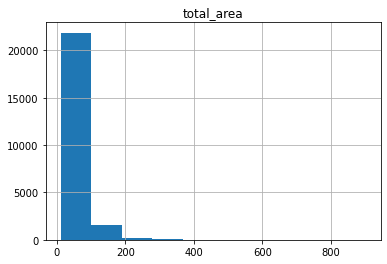

In [341]:
data.hist('total_area')

Из гистограммы видно, что больше всего квартир имеют площадь до 100 м2. Но есть квартиры, площадь которых достигает 900м2. Такие квартиры трудно представить в реальной жизни, поэтому, скорее всего, это выбросы, искажающие диаграмму. Если мы ограничим график более реальными значениями (от 20 до 200 м2), то сможем качественнее проанализировать данные.

count    23650.000000
mean        60.100930
std         35.673519
min         12.000000
25%         40.000000
50%         52.000000
75%         69.000000
max        900.000000
Name: total_area, dtype: float64

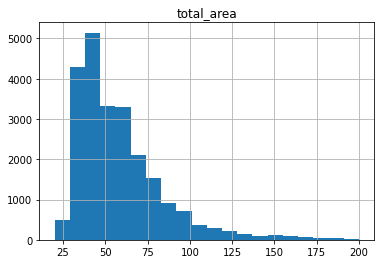

In [342]:
data.hist('total_area', range=(20, 200), bins=20)
data['total_area'].describe()

Диаграмма изменилась: больше квартир (75%) с площадью до 70м2, а с увеличением площади количество квартир уменьшается по экспоненте, с площадью 200+м2 квартир практически нет.

Проанализируем следующий столбец – `last_price`.

array([[<AxesSubplot:title={'center':'last_price'}>]], dtype=object)

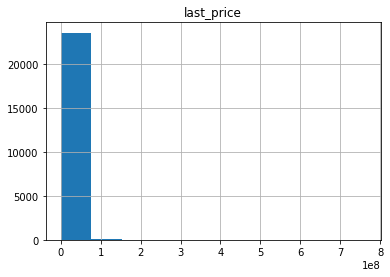

In [343]:
data.hist('last_price')

Трудно хоть что-нибудь указать об этой гистограмме. Большинство данных лежит в пределах от 0 до 60000000. Все остальные значения больше похожи на выбросы. Поэтому проанализируем диаграмму, ограниченную числами 0 и 0.6e8, и разобьем ее на 50 столбцов.

count    2.365000e+04
mean     6.541127e+06
std      1.089640e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.799000e+06
max      7.630000e+08
Name: last_price, dtype: float64

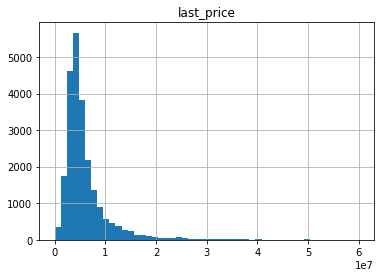

In [344]:
data.hist('last_price', bins=50, range=(0, 0.6e8))
data['last_price'].describe()

Диаграмма напоминает раздел Пуассона. Большинство данных лежит в промежутке от 0 до 1e7, а медиана - 0.5e7.

count    23650.000000
mean         2.070106
std          1.078620
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

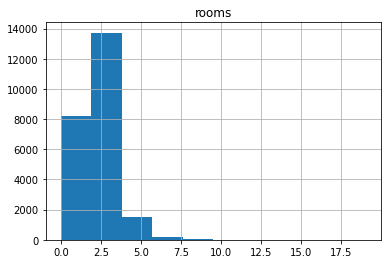

In [345]:
data.hist('rooms')
data['rooms'].describe()

Большинство квартир с количеством комнат от нуля до трех; четырех- или пятикомнатные квартиры встречаются редко. Медиана и среднее значение совпадают и равны 2.

array([[<AxesSubplot:title={'center':'ceiling_height'}>]], dtype=object)

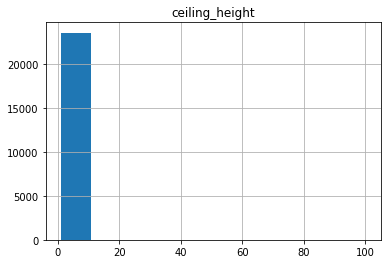

In [346]:
data.hist('ceiling_height')

Из такой гистограммы ничего непонятно. Нужно задать `range` с более реальными высотами потолка.

count    23650.000000
mean         2.724311
std          0.989255
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

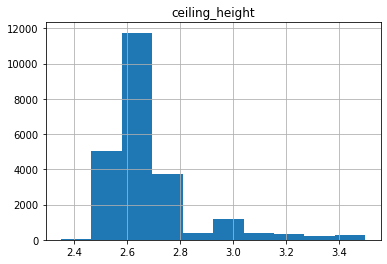

In [347]:
data.hist('ceiling_height', range=(2.35, 3.5))
data['ceiling_height'].describe()

Теперь мы можем проанализировать график. 50% данных лежат в пределах от 2.6 до 2.7, это стандартная высота потолков в современных квартирах. Конечно случаются и квартиры с потолком более 3м, возможно это царские дома.

count    20470.000000
mean       180.753200
std        219.777916
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

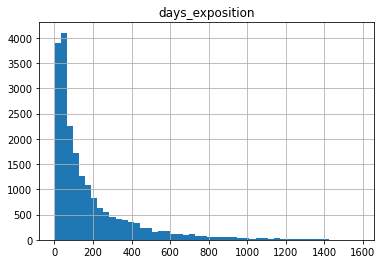

In [348]:
data.hist('days_exposition', bins=50)
data['days_exposition'].describe()

Больше всего квартир продается в первые 100 дней от публикации объявления. Пик находится между 30 и 60 днями, после этого начинает резко спадать. Стандартное отклонение велико, а среднее почти в два раза больше медианы, что свидетельствует о выбросах, которые могли появиться в результате того, что люди забывали удалять объявления после продажи.

### Удаление выбросов

Как мы уже узнали, наши данные переполнены редкими выбивающимися значения. Для того чтобы они не искажали общую картину, нам следует их удалить.

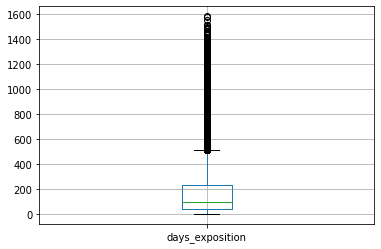

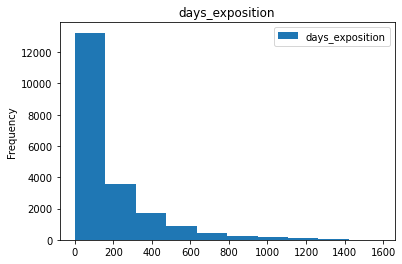

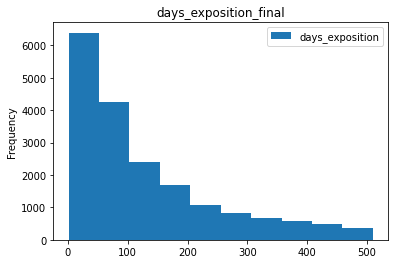

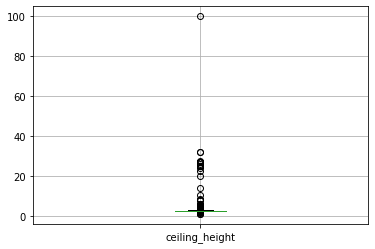

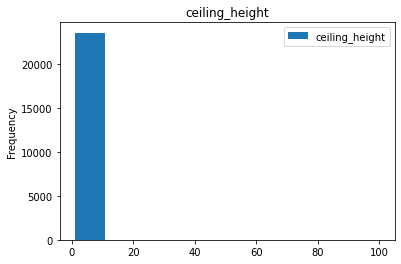

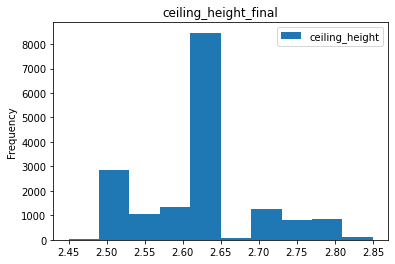

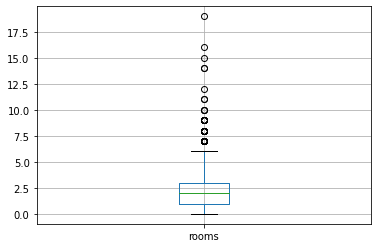

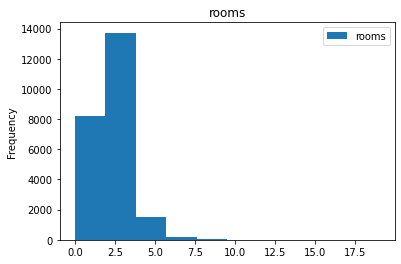

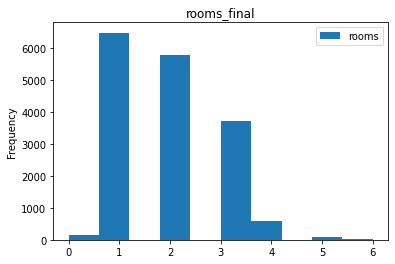

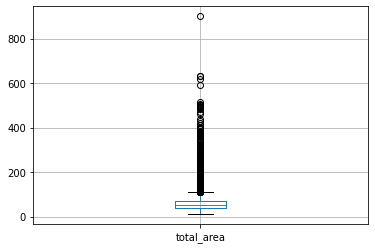

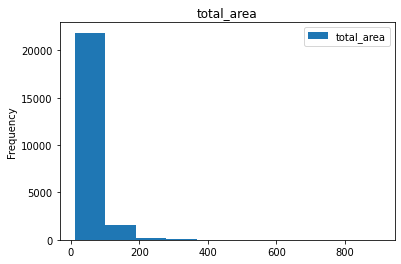

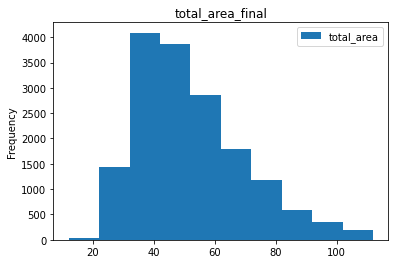

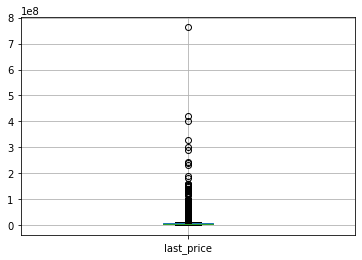

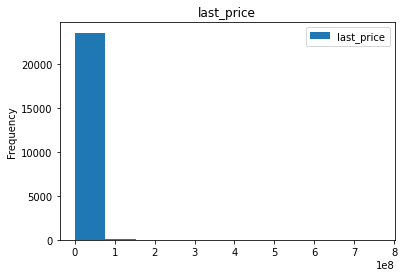

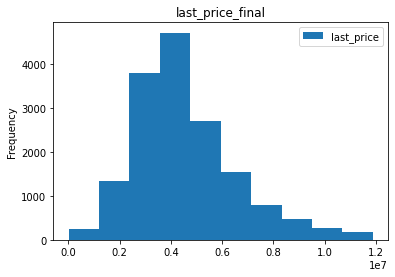

Мы убрали 32.26% данных.


In [349]:
import matplotlib.pyplot as plt

def get_whiskers(dataset):
    q_1 = dataset.quantile(0.25)
    q_3 = dataset.quantile(0.75)
    iqr = q_3 - q_1
    left_whisker = q_1 - 1.5 * iqr
    right_whisker = q_3 + 1.5 * iqr
    return (
        max(dataset.min(), left_whisker),
        min(dataset.max(), right_whisker)
    )

columns = ['days_exposition', 'ceiling_height', 'rooms', 'total_area', 'last_price']

final_data = data
for col in columns:
    data.boxplot(column=col)
    plt.show()
    l_whisker, r_whisker = get_whiskers(data[col])
    final_data = final_data[(final_data[col] >= l_whisker) & (final_data[col] <= r_whisker)]

    data.plot(y=col, kind='hist', title=f'{col}')
    plt.show()

    final_data.plot(y=col, kind='hist', title=f'{col}_final')
    plt.show()
final_data.reset_index()
print(f'Мы убрали {(1 - final_data.shape[0]/data.shape[0]):.2%} данных.')

Хотя мы и уменьшили количество данных аж на 32%, тем самым мы избавились от всех выбросов: квартир с 18 комнатами и с потолками 100м. Теперь мы можем анализировать данные и искать закономерности.

### Какие факторы больше всего влияют на стоимость квартиры?

Исследуем, зависит ли цена от площади, числа комнат и удаленности от центра. Можно построить диаграммы раcсеяния попарно для стоимости и площади, стоимости и количества комнат, стоимости и удаленности от центра и еще 13 вариантов. А для всех пар столбцов можно найти коэффициент корреляции.

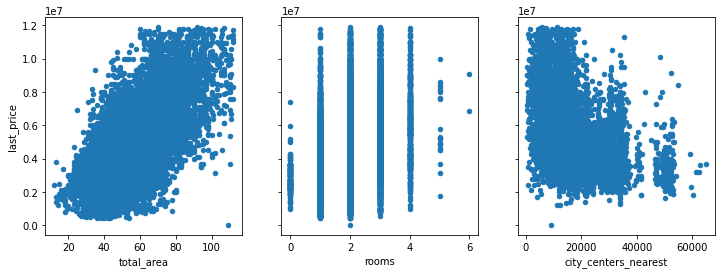

Корреляция с last_price:
total_area              0.685734
rooms                   0.419874
city_centers_nearest   -0.324209
Name: last_price, dtype: float64


In [541]:
# создадим функцию для дальнейшего ее использования

def corr_scatter_matrix(data, cols):
    fig, axes = plt.subplots(nrows=1, ncols=len(cols), figsize=(4*len(cols), 4))
    for i, col in enumerate(cols):
        data.plot(kind='scatter', x=col, y='last_price', ax=axes[i], sharey=True)
    plt.show()
    print('Корреляция с last_price:',  data.corr().loc[cols, 'last_price'], sep='\n')

corr_scatter_matrix(final_data, ['total_area', 'rooms', 'city_centers_nearest'])

Из диаграмм рассеяния видно, что стоимость квартиры (`last_price`) зависит от ее площади (`total_area`), то есть эти две величины коррелируют, и действительно, если посмотреть на коэффициент корреляции, то он равен 0.68, что свидетельствует о средней корреляции.

Слабая корреляция присутствует между такими параметрами, как `last_price` и `rooms`. Студии и однокомнатные квартиры стоят дешевле, но между 2+ комнатными большой разницы в цене не наблюдаем.

Слабая отрицательная корреляция есть между двумя столбцами `last_price` и `city_centers_nearest`. Из диаграммы рассеяния мы можем увидеть, что квартиры, находящиеся вдали от центра, стоят дешево; но также видно, что квартиры в центре или близко к нему тоже могут стоить дешево, а могут и дорого.

А между такими параметрами как `city_centers_nearest` и `rooms` или `city_centers_nearest` и `total_area` корреляция вообще отсутствует.

Проверим, зависит ли цена от дня недели, месяца или года публикации объявления, а также категории этажа.

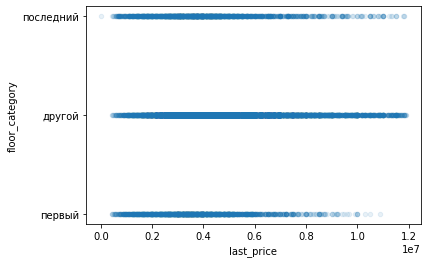

,count,mean,median
,last_price,last_price,last_price
floor_category,,,
другой,12015,4.744176e+06,4350000
первый,1927,3.765021e+06,3556740
последний,2079,4.121628e+06,3800000


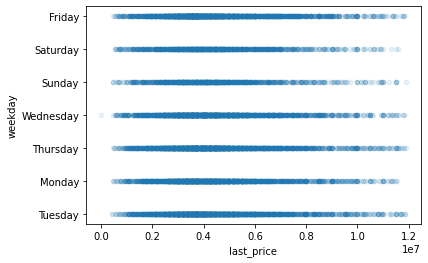

,count,mean,median
,last_price,last_price,last_price
weekday,,,
Friday,2818,4.567933e+06,4168500
Monday,2373,4.525348e+06,4200000
Saturday,1314,4.498695e+06,4200000
Sunday,1184,4.504375e+06,4150000
Thursday,2879,4.568870e+06,4200000
Tuesday,2798,4.562469e+06,4150000
Wednesday,2655,4.538689e+06,4198000


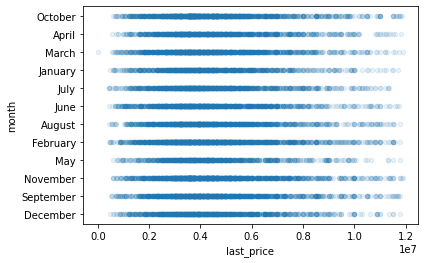

,count,mean,median
,last_price,last_price,last_price
month,,,
April,1178,4.607921e+06,4250000
August,1293,4.594407e+06,4200000
December,1105,4.508018e+06,4160000
February,1805,4.550144e+06,4200000
January,1006,4.513735e+06,4200000
July,1219,4.492320e+06,4100000
June,1304,4.406793e+06,4050000
March,1506,4.488393e+06,4150000


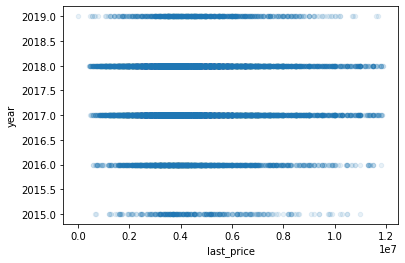

,count,mean,median
,last_price,last_price,last_price
year,,,
2015,385,4.730265e+06,4350000
2016,1751,4.538238e+06,4150000
2017,6452,4.532425e+06,4100000
2018,6496,4.512158e+06,4200000
2019,937,4.806347e+06,4500000


In [555]:
# создадим функцию для дальнейшего ее использования
def scatter_plots(data, columns):
    for col in columns:
        data.plot(x='last_price', y=col, kind='scatter', alpha=0.1)
        plt.show()
        # выведем еще количество уникальных данных и их среднее для каждого столбца
        display(data.pivot_table(index=col, values='last_price', aggfunc=['count', 'mean', 'median']))

scatter_plots(final_data, ['floor_category', 'weekday', 'month', 'year'])

Дешевле всего стоят квартиры на первом этаже. Хотя линия квартир, находящихся на ***другом*** этаже, насыщеннее, чем линия квартир на ***последнем*** этаже - это еще не говорит о том, что эти квартиры стоят дороже; это может быть связано с бОльшим количеством данных; тем более ценовой диапазон квартир на ***последнем*** этаже соответствует ценовому диапазону квартир на ***другом*** этаже.

День публикации почти не влияет на стоимость квартиры, только в только в ***понедельник*** меньше дорогих квартир. А еще можно увидеть, что в ***субботу*** и ***воскресенье*** люди менее активно публикуют объявления.

Наиболее выгодно покупать квартиру в ***июле***, а вот ***осенние месяцы*** могут быть менее привлекательны для покупателей. Но трудно сказать, что между месяцем публикации и ценой есть хотя бы средняя зависимость, больше похожая на слабую или вообще ее отсутствие.

Если смотреть только на диаграмму, можно сделать выводы, что в ***2015*** и ***2019*** годах квартиры стоили дешевле всего. А в ***2017*** и ***2018*** – наиболее дорогие. Но по ***2015*** и ***2019*** годах у нас меньше всего данных, поэтому их диаграммы рассеяния выглядят по-другому. Однако если смотреть на среднюю цену квартиры по последним трем годам, мы можем увидеть тренд подорожания, что и логично в связи с инфляцией.

**Вывод**
Мы изучили зависимость меж ценой и другими характеристиками квартир. И можем утверждать, что существует связь между площадью квартиры и ценой, между количеством комнат и ценой, а также средняя отрицательная корреляция между ценой и удаленностью от центра. День и месяц публикации никак не влияет на цену, а с годом есть посредственная связь.

Теперь мы выберем 10 населённых пунктов с наибольшим числом объявлений. Посчитаем среднюю цену квадратного метра в этих населённых пунктах. Выделим населённые пункты с самой высокой и низкой стоимостью жилья.

In [352]:
(
    final_data.pivot_table(index='locality_name_unique', values='price_m2', aggfunc=['count', 'mean'])
    .sort_values(by=('count', 'price_m2'), ascending=False)
    [0:10]
    .sort_values(by=('mean', 'price_m2'), ascending=False)
)

,count,mean
,price_m2,price_m2
locality_name_unique,,
Санкт-Петербург,10033,104174.480676
Пушкин,232,99195.351509
Кудрово,403,95164.664864
Парголово,287,89827.917108
Мурино,512,86586.334238
Шушары,382,78292.489267
Колпино,275,75030.164218
Гатчина,227,68130.067930


В Санкт-Петербурге самое большое количество объявлений, а также самая дорогая цена за квадратный метр. Во всех других населенных пунктах количество объявлений минимум в 20 раз меньше, а средняя цена за квадратный метр отличается на пару тысяч. Самая дешевая стоимость квартиры в городе Выборг.

Будем исследовать квартиры в Санкт-Петербурге. Для начала определим, какая область входит в центр города.

<AxesSubplot:xlabel='city_centers_nearest_km'>

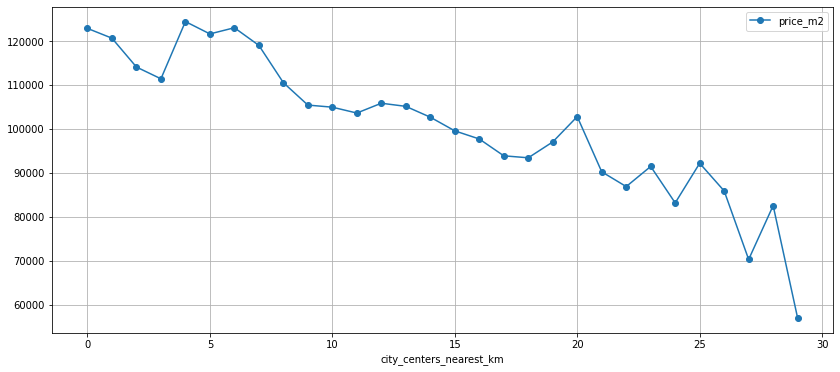

In [485]:
data_spb = final_data.query('locality_name_unique == "Санкт-Петербург"').copy()
data_spb['city_centers_nearest_km'] = final_data['city_centers_nearest'] // 1000
(
    data_spb.pivot_table(index='city_centers_nearest_km', values='price_m2', aggfunc='mean')
    .plot(style='o-', grid=True, figsize=(14, 6))
)

Из графика видно, что 8км – это переломная точка, после которой график хотя и колеблется, но никогда не превышает цену этой точки, то есть идет на спад.

Теперь выделим сегмент квартир в центре и сравним некоторые средние значения со средними значениями по всему городу.

In [529]:
data_spb_center = data_spb.query('city_centers_nearest_km < 8').copy()

columns = ['floors_total', 'ceiling_height', 'days_exposition', 'total_area', 'price_m2', 'rooms']

(
    pd.DataFrame(data_spb_center[columns].mean()).transpose()
    .append(
        pd.DataFrame(data_spb[columns].mean()).transpose()
    )
)

,floors_total,ceiling_height,days_exposition,total_area,price_m2,rooms
0,8.203478,2.657896,134.703478,59.503478,120371.401809,2.076522
0,12.278082,2.631421,119.426792,51.420911,104174.480676,1.870527


Центр города застроен более низкими домами по сравнению со всем Санкт-Петербургом. Но высота потолков в этих домах в среднем немного выше. БОльшая и общая площадь квартиры и количество комнат. Также в этом районе выше цена квадратного метра, но продаются они в среднем медленнее.

Проанализируем факторы, влияющие на формирование цены и сравним результат с данными по всему городу.

Санкт-Петербург:


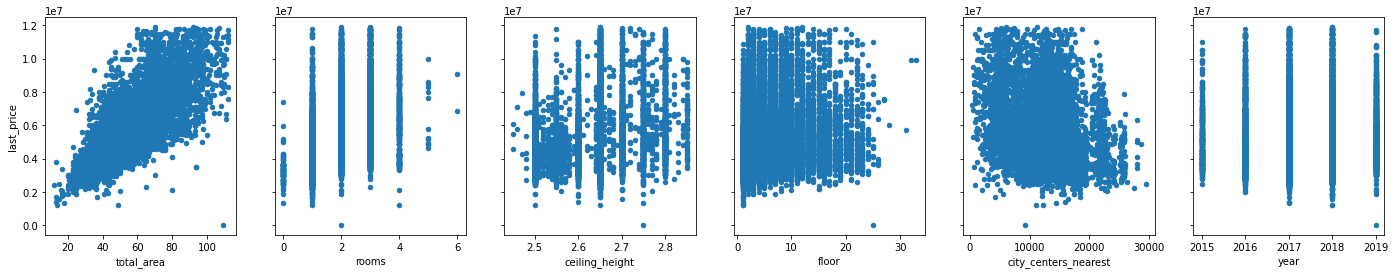

Корреляция с last_price:
total_area              0.793269
rooms                   0.485424
ceiling_height          0.270538
floor                   0.125665
city_centers_nearest   -0.278264
year                    0.023927
Name: last_price, dtype: float64


Центр Санкт-Петербурга:


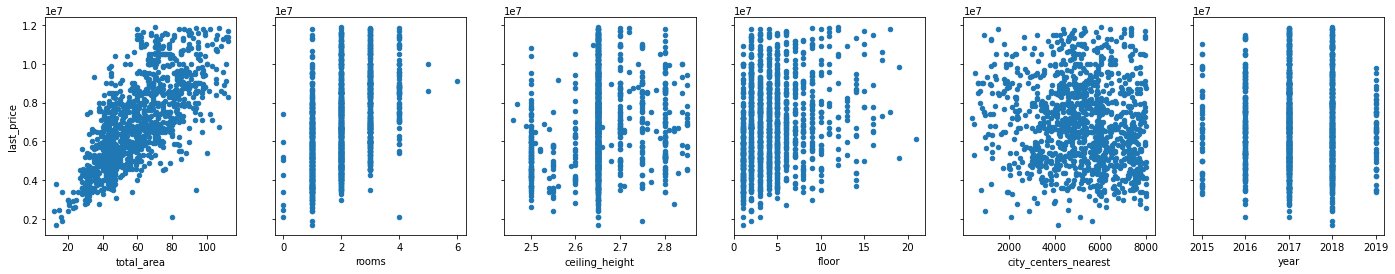

Корреляция с last_price:
total_area              0.715480
rooms                   0.427743
ceiling_height          0.183250
floor                   0.201713
city_centers_nearest   -0.121968
year                   -0.003369
Name: last_price, dtype: float64


In [536]:
corr_cols = ['total_area', 'rooms', 'ceiling_height', 'floor', 'city_centers_nearest', 'year']
print('Санкт-Петербург:')
corr_scatter_matrix(data_spb, corr_cols)
print('\n')
print('Центр Санкт-Петербурга:')
corr_scatter_matrix(data_spb_center, corr_cols)

Наибольший коэффициент корреляции можно увидеть между ценой и общей площадью квартиры; он немного выше для центра города.

Так как количество комнат коррелирует с общей площадью, то и соответственно стоимость зависит от количества комнат.

Квартиры, которые находятся выше этажом, продаются дороже в центре; а на выборке всего города этаж не влияет на цену.

Логично, что для находящихся в центре квартир удаленность от центра не вносит никаких изменений в цену, однако если анализировать весь город, то можно увидеть, что между ценой и удаленностью от центра есть небольшая отрицательная корреляция.

По всему городу квартиры с более высокой высотой потолки продаются дороже (КК=0.27), для центра коэффициент корреляции меньше - 0.18.

Посмотрим, как с годами меняется цена квартир в центре и городе:

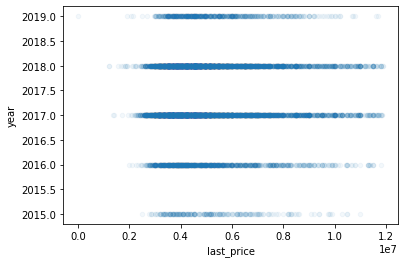

,count,mean,median
,last_price,last_price,last_price
year,,,
2015,254,5.271313e+06,4965000
2016,1125,5.228583e+06,4750000
2017,4114,5.234876e+06,4700000
2018,3870,5.320065e+06,4800000
2019,670,5.409800e+06,5000000


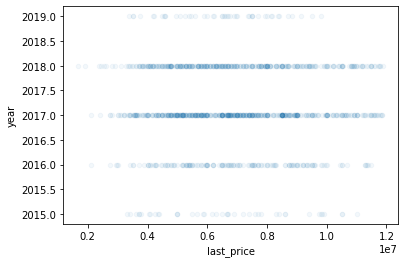

,count,mean,median
,last_price,last_price,last_price
year,,,
2015,42,6.632856e+06,6574500
2016,160,6.916533e+06,6775000
2017,523,6.951953e+06,6772762
2018,378,6.943707e+06,6650000
2019,47,6.467191e+06,6600000


In [549]:
scatter_plots(data_spb, ['year'])
scatter_plots(data_spb_center, ['year'])

Интересно, что с течением времени стоимость квартир не меняется, а в центре вообще падает. Посмотрим теперь на то, как меняется цена квадратного метра.

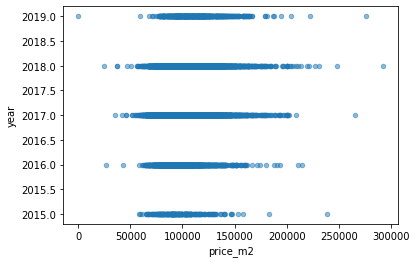

,count,mean,median
,price_m2,price_m2,price_m2
year,,,
2015,254,97962.336575,95093.375
2016,1125,100377.414142,97333.330
2017,4114,101800.631001,98750.000
2018,3870,106627.076811,103333.330
2019,670,113314.861224,110540.940


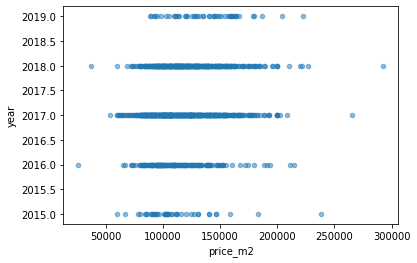

,count,mean,median
,price_m2,price_m2,price_m2
year,,,
2015,42,111077.501190,103875.000
2016,160,113587.326563,109213.085
2017,523,118823.425105,114736.840
2018,378,124182.202963,119663.075
2019,47,138348.100638,140000.000


In [550]:
for data in [data_spb, data_spb_center]:
    data.plot(x='price_m2', y='year', kind='scatter', alpha=0.5)
    plt.show()
    display(data.pivot_table(index='year', values='price_m2', aggfunc=['count', 'mean', 'median']))

Цена квадратного метра все же растет. Теперь можем посмотреть, как меняется площадь квартиры. Создадим сводную таблицу:

In [554]:
for data in [data_spb, data_spb_center]:
    display(
        data.pivot_table(
            index='year',
            values=['price_m2', 'total_area', 'last_price'],
            aggfunc=['mean']
        )
    )

mean                          
        last_price       price_m2 total_area
year                                        
2015  5.271313e+06   97962.336575  55.039370
2016  5.228583e+06  100377.414142  52.877333
2017  5.234876e+06  101800.631001  52.048614
2018  5.320065e+06  106627.076811  50.530233
2019  5.409800e+06  113314.861224  48.894030

mean                          
        last_price       price_m2 total_area
year                                        
2015  6.632856e+06  111077.501190  61.880952
2016  6.916533e+06  113587.326563  63.237500
2017  6.951953e+06  118823.425105  60.652008
2018  6.943707e+06  124182.202963  57.468254
2019  6.467191e+06  138348.100638  48.255319

С течением времени общая площадь продаваемых квартир в среднем уменьшается, а цена за квадратный метр - растет. Это и объясняет то, что цена за квартиру практически не меняется с годами или совсем становится меньше.

## Общий вывод